In [85]:
# 📦 Procesamiento de datos
import pandas as pd
import numpy as np
import scipy.stats as stats

# 🤖 Modelado
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from scipy.stats import ks_2samp

# 📊 Visualización
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

In [86]:
# LEYENDO LA BASE DE DATOS
df = pd.read_csv('/content/dataset_prueba.csv', sep=',')

In [87]:
# Normalizar fecha
df['last_date_of_month'] = pd.to_datetime(df['last_date_of_month'], errors='coerce')

In [88]:
# Separar train (junio + julio 2014) y test (agosto 2014)
train_dates = [pd.Timestamp('2014-06-30'), pd.Timestamp('2014-07-31')]
test_date = pd.Timestamp('2014-08-31')

In [89]:
df_train = df[df['last_date_of_month'].isin(train_dates)].copy()
df_test  = df[df['last_date_of_month']==test_date].copy()

In [90]:
### PREGUNTA 1 ###
if 'arpu' not in df_train.columns:
    raise Exception("No se encontró la columna 'arpu' en el dataset. Revisa el CSV.")
valid_arpu = df_train['arpu'].dropna()
deciles = valid_arpu.quantile([0.9, 0.8])
top_decile_threshold = deciles.loc[0.9]
second_threshold = deciles.loc[0.8]

def clasificacion_arpu(x):
    if pd.isna(x):
        return 'normal'
    if x >= top_decile_threshold:
        return 'platino'
    elif x >= second_threshold:
        return 'gold'
    else:
        return 'normal'

df_train['clasificacion_clientes_revenue'] = df_train['arpu'].apply(clasificacion_arpu)
counts_p1 = df_train['clasificacion_clientes_revenue'].value_counts().reindex(['platino','gold','normal']).fillna(0).astype(int)
print(counts_p1)

clasificacion_clientes_revenue
platino     19940
gold        19941
normal     159516
Name: count, dtype: int64


In [91]:
### PREGUNTA 2 ###
df_train['flag_recarga'] = np.where(df_train['total_rech_num'].fillna(0) > 0, 1, 0)
counts_p2 = df_train['flag_recarga'].value_counts().reindex([1,0]).fillna(0).astype(int)
print(counts_p2)

flag_recarga
1    196624
0      2773
Name: count, dtype: int64


In [92]:
### PREGUNTA 3 ###
prop_jun = df_train[df_train['last_date_of_month'] == '2014-06-30']['churn'].mean()
prop_jul = df_train[df_train['last_date_of_month'] == '2014-07-31']['churn'].mean()
print(f"Junio 2014: {prop_jun:.4f}")
print(f"Julio 2014: {prop_jul:.4f}")

Junio 2014: 0.0104
Julio 2014: 0.0152


In [93]:
### PREGUNTA 4 ####
# ---------- P4: Columnas > 70% nulos (en train) ----------
threshold = 0.70
null_pct = df_train.isna().mean()
cols_to_drop = null_pct[null_pct > threshold].index.tolist()
num_dropped = len(cols_to_drop)
print(num_dropped)

10


In [94]:
df_train= df_train.drop(columns=cols_to_drop)
df_train.info(show_counts=True,verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 199397 entries, 99999 to 299996
Data columns (total 48 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   last_date_of_month              199397 non-null  datetime64[ns]
 1   arpu                            199397 non-null  float64       
 2   onnet_mou                       192202 non-null  float64       
 3   offnet_mou                      192202 non-null  float64       
 4   roam_ic_mou                     192202 non-null  float64       
 5   roam_og_mou                     192202 non-null  float64       
 6   loc_og_t2t_mou                  192202 non-null  float64       
 7   loc_og_t2m_mou                  192202 non-null  float64       
 8   loc_og_t2f_mou                  192202 non-null  float64       
 9   loc_og_t2c_mou                  192202 non-null  float64       
 10  loc_og_mou                      192202 non-null  float64 

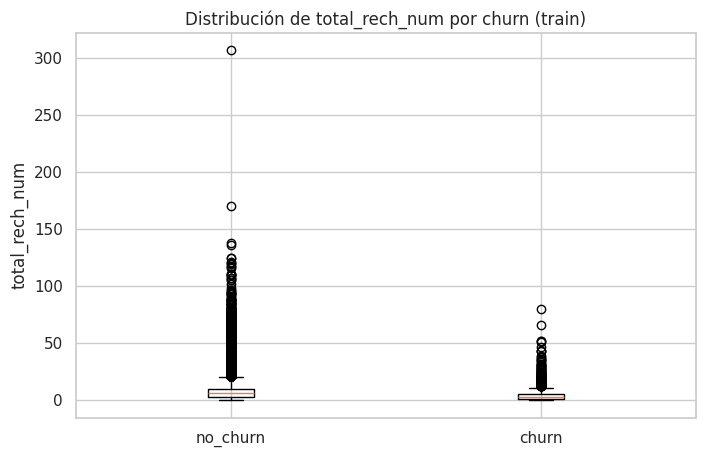

In [95]:
### PREGUNTA 5 ###

# Grupos
group0 = df_train[df_train['churn']==0]['total_rech_num'].fillna(0)
group1 = df_train[df_train['churn']==1]['total_rech_num'].fillna(0)

# Boxplot
plt.figure(figsize=(8,5))
plt.boxplot([group0, group1], tick_labels=['no_churn','churn'])
plt.title('Distribución de total_rech_num por churn (train)')
plt.ylabel('total_rech_num')
plt.show()


# MODELO

In [96]:
# Verificar duplicados
print("### Verificar y eliminar duplicados ###")
duplicados=df_train.duplicated().sum()
print(f"Cantidad de filas duplicadas: {duplicados}")
# Eliminar duplicados del DataFrame
df_train = df_train.drop_duplicates()

# Verificar el número de filas antes y después de eliminar los duplicados
print(f"Filas después de eliminar duplicados: {len(df_train)}")

### Verificar y eliminar duplicados ###
Cantidad de filas duplicadas: 0
Filas después de eliminar duplicados: 199397


In [97]:

if 'arpu' not in df_train.columns:
    raise Exception("No se encontró la columna 'arpu' en el dataset. Revisa el CSV.")
valid_arpu = df_test['arpu'].dropna()
deciles = valid_arpu.quantile([0.9, 0.8])
top_decile_threshold = deciles.loc[0.9]
second_threshold = deciles.loc[0.8]

def clasificacion_arpu(x):
    if pd.isna(x):
        return 'normal'
    if x >= top_decile_threshold:
        return 'platino'
    elif x >= second_threshold:
        return 'gold'
    else:
        return 'normal'

df_test['clasificacion_clientes_revenue'] = df_test['arpu'].apply(clasificacion_arpu)
counts_p1 = df_test['clasificacion_clientes_revenue'].value_counts().reindex(['platino','gold','normal']).fillna(0).astype(int)
print(counts_p1)

clasificacion_clientes_revenue
platino     9890
gold        9890
normal     79119
Name: count, dtype: int64


In [98]:
df_test['flag_recarga'] = np.where(df_test['total_rech_num'].fillna(0) > 0, 1, 0)
counts_p2 = df_test['flag_recarga'].value_counts().reindex([1,0]).fillna(0).astype(int)
print(counts_p2)

flag_recarga
1    96377
0     2522
Name: count, dtype: int64


In [99]:
# ---------- P4: Columnas > 70% nulos (en train) ----------
threshold = 0.70
null_pct = df_test.isna().mean()
cols_to_drop = null_pct[null_pct > threshold].index.tolist()
num_dropped = len(cols_to_drop)
print(num_dropped)

10


In [100]:
df_test= df_test.drop(columns=cols_to_drop)
df_test.info(show_counts=True,verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 98899 entries, 0 to 99998
Data columns (total 48 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   last_date_of_month              98899 non-null  datetime64[ns]
 1   arpu                            98899 non-null  float64       
 2   onnet_mou                       94621 non-null  float64       
 3   offnet_mou                      94621 non-null  float64       
 4   roam_ic_mou                     94621 non-null  float64       
 5   roam_og_mou                     94621 non-null  float64       
 6   loc_og_t2t_mou                  94621 non-null  float64       
 7   loc_og_t2m_mou                  94621 non-null  float64       
 8   loc_og_t2f_mou                  94621 non-null  float64       
 9   loc_og_t2c_mou                  94621 non-null  float64       
 10  loc_og_mou                      94621 non-null  float64       
 11  std_og_

In [101]:
import pandas as pd

def variables_con_nulos(df,
                        exclude_cols=['mobile_number', 'date_of_last_rech', 'churn']):
    """
    Retorna un DataFrame con el % de valores nulos por variable,
    excluyendo las columnas indicadas.
    """
    # Filtrar columnas a evaluar
    cols_eval = [c for c in df.columns if c not in exclude_cols]

    # Calcular % de nulos
    n = len(df)
    null_pct = df[cols_eval].isna().sum() / n * 100

    # Crear DataFrame con resultados
    resultado = (
        null_pct[null_pct > 0]  # solo variables con al menos 1 nulo
        .sort_values(ascending=False)
        .reset_index()
        .rename(columns={'index': 'Variable', 0: 'Pct_nulos'})
    )

    print("📌 Variables con nulos (excluyendo columnas indicadas):")
    print(resultado)

    return resultado

variables_con_nulos(df_train,
                    exclude_cols=['mobile_number', 'date_of_last_rech', 'churn'])


📌 Variables con nulos (excluyendo columnas indicadas):
          Variable  Pct_nulos
0        onnet_mou   3.608379
1       offnet_mou   3.608379
2      roam_ic_mou   3.608379
3      roam_og_mou   3.608379
4   loc_og_t2t_mou   3.608379
5   loc_og_t2m_mou   3.608379
6   loc_og_t2f_mou   3.608379
7   loc_og_t2c_mou   3.608379
8       loc_og_mou   3.608379
9   std_og_t2t_mou   3.608379
10  std_og_t2m_mou   3.608379
11  std_og_t2f_mou   3.608379
12  std_og_t2c_mou   3.608379
13      std_og_mou   3.608379
14      isd_og_mou   3.608379
15      spl_og_mou   3.608379
16       og_others   3.608379
17  loc_ic_t2t_mou   3.608379
18  loc_ic_t2m_mou   3.608379
19  loc_ic_t2f_mou   3.608379
20      loc_ic_mou   3.608379
21  std_ic_t2t_mou   3.608379
22  std_ic_t2m_mou   3.608379
23  std_ic_t2f_mou   3.608379
24  std_ic_t2o_mou   3.608379
25      std_ic_mou   3.608379
26      spl_ic_mou   3.608379
27      isd_ic_mou   3.608379
28       ic_others   3.608379


,Variable,Pct_nulos
0,onnet_mou,3.608379
1,offnet_mou,3.608379
2,roam_ic_mou,3.608379
3,roam_og_mou,3.608379
4,loc_og_t2t_mou,3.608379
5,loc_og_t2m_mou,3.608379
6,loc_og_t2f_mou,3.608379
7,loc_og_t2c_mou,3.608379
8,loc_og_mou,3.608379
9,std_og_t2t_mou,3.608379


In [102]:
variables_con_nulos(df_test,
                    exclude_cols=['mobile_number', 'date_of_last_rech', 'churn'])

📌 Variables con nulos (excluyendo columnas indicadas):
          Variable  Pct_nulos
0        onnet_mou   4.325625
1       offnet_mou   4.325625
2      roam_ic_mou   4.325625
3      roam_og_mou   4.325625
4   loc_og_t2t_mou   4.325625
5   loc_og_t2m_mou   4.325625
6   loc_og_t2f_mou   4.325625
7   loc_og_t2c_mou   4.325625
8       loc_og_mou   4.325625
9   std_og_t2t_mou   4.325625
10  std_og_t2m_mou   4.325625
11  std_og_t2f_mou   4.325625
12  std_og_t2c_mou   4.325625
13      std_og_mou   4.325625
14      isd_og_mou   4.325625
15      spl_og_mou   4.325625
16       og_others   4.325625
17  loc_ic_t2t_mou   4.325625
18  loc_ic_t2m_mou   4.325625
19  loc_ic_t2f_mou   4.325625
20      loc_ic_mou   4.325625
21  std_ic_t2t_mou   4.325625
22  std_ic_t2m_mou   4.325625
23  std_ic_t2f_mou   4.325625
24  std_ic_t2o_mou   4.325625
25      std_ic_mou   4.325625
26      spl_ic_mou   4.325625
27      isd_ic_mou   4.325625
28       ic_others   4.325625


,Variable,Pct_nulos
0,onnet_mou,4.325625
1,offnet_mou,4.325625
2,roam_ic_mou,4.325625
3,roam_og_mou,4.325625
4,loc_og_t2t_mou,4.325625
5,loc_og_t2m_mou,4.325625
6,loc_og_t2f_mou,4.325625
7,loc_og_t2c_mou,4.325625
8,loc_og_mou,4.325625
9,std_og_t2t_mou,4.325625


In [103]:
import pandas as pd
import numpy as np

def imputar_valores(df, exclude_cols=['mobile_number', 'date_of_last_rech', 'churn'], umbral=5.0):
    """
    Imputa valores nulos, vacíos o 'NA' solo en columnas cuyo % de nulidad es menor al umbral (< 5% por defecto).
    - Numéricas simétricas: media
    - Numéricas sesgadas: mediana
    - Categóricas: moda
    """
    df_copy = df.copy()

    # Reemplazar valores vacíos y 'NA' por np.nan
    df_copy = df_copy.replace(["", " ", "NA", "N/A", "na", "NaN"], np.nan)

    n = len(df_copy)

    for col in df_copy.columns:
        if col in exclude_cols:
            continue

        # % de nulos en la columna
        pct_null = df_copy[col].isna().sum() / n * 100

        if pct_null == 0:
            continue  # no tiene nulos
        elif pct_null >= umbral:
            print(f"⚠️ {col}: {pct_null:.2f}% valores nulos/vacíos → NO se imputa (≥ {umbral}%)")
            continue

        # Numéricas
        if pd.api.types.is_numeric_dtype(df_copy[col]):
            skewness = df_copy[col].skew(skipna=True)
            if abs(skewness) < 1:
                valor = df_copy[col].mean(skipna=True)
                metodo = "media"
            else:
                valor = df_copy[col].median(skipna=True)
                metodo = "mediana"
            df_copy[col] = df_copy[col].fillna(valor)
            print(f"📌 {col}: {pct_null:.2f}% nulos/vacíos imputados con {metodo}")

        # Categóricas
        else:
            valor = df_copy[col].mode(dropna=True)[0]
            df_copy[col] = df_copy[col].fillna(valor)
            print(f"📌 {col}: {pct_null:.2f}% nulos/vacíos imputados con moda")

    return df_copy

# ============================
# USO
# ============================
df_train = imputar_valores(df_train, exclude_cols=['mobile_number', 'date_of_last_rech', 'churn'], umbral=5.0)
df_test  = imputar_valores(df_test,  exclude_cols=['mobile_number', 'date_of_last_rech', 'churn'], umbral=5.0)


📌 onnet_mou: 3.61% nulos/vacíos imputados con mediana
📌 offnet_mou: 3.61% nulos/vacíos imputados con mediana
📌 roam_ic_mou: 3.61% nulos/vacíos imputados con mediana
📌 roam_og_mou: 3.61% nulos/vacíos imputados con mediana
📌 loc_og_t2t_mou: 3.61% nulos/vacíos imputados con mediana
📌 loc_og_t2m_mou: 3.61% nulos/vacíos imputados con mediana
📌 loc_og_t2f_mou: 3.61% nulos/vacíos imputados con mediana
📌 loc_og_t2c_mou: 3.61% nulos/vacíos imputados con mediana
📌 loc_og_mou: 3.61% nulos/vacíos imputados con mediana
📌 std_og_t2t_mou: 3.61% nulos/vacíos imputados con mediana
📌 std_og_t2m_mou: 3.61% nulos/vacíos imputados con mediana
📌 std_og_t2f_mou: 3.61% nulos/vacíos imputados con mediana
📌 std_og_t2c_mou: 3.61% nulos/vacíos imputados con media
📌 std_og_mou: 3.61% nulos/vacíos imputados con mediana
📌 isd_og_mou: 3.61% nulos/vacíos imputados con mediana
📌 spl_og_mou: 3.61% nulos/vacíos imputados con mediana
📌 og_others: 3.61% nulos/vacíos imputados con mediana
📌 loc_ic_t2t_mou: 3.61% nulos/vacío

In [104]:

## LASSO
def seleccionar_variables_lasso(df,
                                id_cols=['last_date_of_month','mobile_number', 'date_of_last_rech'],
                                target_col='churn'):
    """
    Selecciona variables relevantes usando LassoCV.
    - Excluye columnas no predictoras (id_cols + target_col).
    - Escala numéricas.
    - Devuelve:
        - DataFrame con coeficientes ≠ 0
        - Lista con nombres de variables seleccionadas
    """

    df_modelo = df.drop(columns=id_cols + [target_col], errors='ignore')

    X = df_modelo.select_dtypes(include=[np.number]).copy()
    y = df[target_col]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    lasso = LassoCV(cv=5, random_state=42)
    lasso.fit(X_scaled, y)

    coef = pd.Series(lasso.coef_, index=X.columns)

    relevantes = coef[coef != 0]
    resultado = relevantes.sort_values(key=abs, ascending=False).to_frame(name='Coeficiente')
    variables_seleccionadas = resultado.index.tolist()

    print(f"\n📌 Variables seleccionadas por Lasso (coeficiente ≠ 0):")
    print(resultado)
    print(f"\n📌 Vector de variables seleccionadas: {variables_seleccionadas}")

    return resultado, variables_seleccionadas

resultado_lasso, vars_lasso = seleccionar_variables_lasso(
    df_train,
    id_cols=['last_date_of_month','mobile_number', 'date_of_last_rech'],
    target_col='churn'
)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.45136407015797886, tolerance: 0.19125034698496501
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20987891320419294, tolerance: 0.19797989255133117
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3500802937580829, tolerance: 0.2087931343171199
  model = cd_fast.enet_coordinate_descent_gram(



📌 Variables seleccionadas por Lasso (coeficiente ≠ 0):
                  Coeficiente
total_ic_mou        -0.369443
loc_ic_t2m_mou       0.164896
onnet_mou            0.162695
offnet_mou           0.162126
total_og_mou        -0.157008
loc_ic_t2t_mou       0.138629
isd_ic_mou           0.077109
std_ic_t2m_mou       0.072339
loc_ic_mou           0.065624
std_og_t2t_mou      -0.055899
loc_og_t2t_mou      -0.055081
loc_og_t2m_mou      -0.053107
std_ic_t2t_mou       0.048376
std_og_t2m_mou      -0.047906
loc_ic_t2f_mou       0.040439
std_ic_mou           0.039913
loc_og_mou           0.035557
roam_og_mou         -0.034807
ic_others            0.015080
std_ic_t2f_mou       0.014051
arpu                 0.013783
total_rech_amt      -0.007841
isd_og_mou          -0.006100
loc_og_t2f_mou      -0.005533
flag_recarga        -0.005372
monthly_3g          -0.003016
std_og_t2f_mou      -0.002073
monthly_2g          -0.001590
vol_3g_mb           -0.001449
total_rech_num      -0.001422
spl_og_mou    

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.632e+02, tolerance: 2.518e-01
  model = cd_fast.enet_coordinate_descent(


In [105]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from scipy.stats import ks_2samp

# ============================
# Función para calcular Gini y KS respecto al target
# ============================
def gini_ks(y_true, y_score):
    mask = (~pd.isnull(y_true)) & (~pd.isnull(y_score))
    y_true = y_true[mask]
    y_score = y_score[mask]

    if len(np.unique(y_score)) <= 1:
        return {'Gini': np.nan, 'KS': np.nan}

    auc = roc_auc_score(y_true, y_score)
    gini = abs(2 * auc - 1)  # Valor absoluto
    ks = ks_2samp(y_score[y_true == 1], y_score[y_true == 0]).statistic

    return {'Gini': gini, 'KS': ks}

# ============================
# Evaluar solo variables seleccionadas por Lasso
# ============================
excluir = ['last_date_of_month','mobile_number','date_of_last_rech','churn']
vars_filtradas = [v for v in vars_lasso if v not in excluir]

results = []
for var in vars_filtradas:
    if df_train[var].dtype in [np.float64, np.int64]:
        # Numéricas
        vals = gini_ks(df_train['churn'], df_train[var])
    else:
        # Categóricas → factorizar
        encoded = pd.factorize(df_train[var])[0]
        vals = gini_ks(df_train['churn'], encoded)

    results.append({'Variable': var, 'Gini': vals['Gini'], 'KS': vals['KS']})

results_df = pd.DataFrame(results)

# ============================
# Resultados finales
# ============================
results_df = results_df.dropna().copy()
results_df['Gini'] = results_df['Gini'].round(4)
results_df['KS'] = results_df['KS'].round(4)
results_df = results_df.sort_values(by='Gini', ascending=False)

# ============================
# Filtrar variables relevantes
# ============================
variables_relevantes = results_df[
    (results_df['Gini'] > 0.02) & (results_df['KS'] > 0.02)
].copy()

# Vector con nombres de variables finales que cumplen con el criterio
variables_finales = variables_relevantes['Variable'].tolist()

# Mensaje personalizado
if variables_finales:
    print("🎯 Variables de Lasso con Gini y KS mayores a 0.02:")
    print(variables_relevantes[['Variable', 'Gini', 'KS']])
    print(f"\n✅ Vector de variables finales:\n{variables_finales}")
else:
    print("⚠️ No se encontraron variables de Lasso con Gini y KS mayores a 0.02.")

# ============================
# Mostrar top 30 por Gini (solo de vars_lasso)
# ============================
print("\n📌 Top 30 variables (de Lasso) por Gini:")
print(results_df.head(60))


🎯 Variables de Lasso con Gini y KS mayores a 0.02:
            Variable    Gini      KS
0       total_ic_mou  0.5829  0.4796
4       total_og_mou  0.5181  0.4613
29    total_rech_num  0.4719  0.3685
21    total_rech_amt  0.4613  0.3777
40      max_rech_amt  0.4021  0.3596
20              arpu  0.3942  0.3038
35  last_day_rch_amt  0.3169  0.3003
23    loc_og_t2f_mou  0.2580  0.2549
12    std_ic_t2t_mou  0.2240  0.2189
9     std_og_t2t_mou  0.2173  0.2153
30        spl_og_mou  0.1864  0.1936
33         vol_2g_mb  0.1474  0.1450
8         loc_ic_mou  0.1434  0.3384
19    std_ic_t2f_mou  0.1372  0.1358
1     loc_ic_t2m_mou  0.1370  0.3365
18         ic_others  0.1289  0.1299
16        loc_og_mou  0.1243  0.3241
5     loc_ic_t2t_mou  0.1216  0.3212
24      flag_recarga  0.1185  0.1185
11    loc_og_t2m_mou  0.1165  0.3216
10    loc_og_t2t_mou  0.1117  0.3105
37        spl_ic_mou  0.1001  0.1002
6         isd_ic_mou  0.0929  0.0931
28         vol_3g_mb  0.0911  0.0893
3         offnet_mou  0.

In [106]:
import pandas as pd
import numpy as np

# ============================
# Función para calcular IV (usando WOE internamente)
# ============================
def calcular_iv(df, feature, target, bins=10):
    df_temp = df[[feature, target]].copy()

    # Binning si es numérica
    if pd.api.types.is_numeric_dtype(df_temp[feature]):
        df_temp['bin'] = pd.qcut(
            df_temp[feature].rank(method='first'),
            q=bins,
            duplicates='drop'
        )
    else:
        df_temp['bin'] = df_temp[feature]

    grouped = df_temp.groupby('bin')

    total_events = (df_temp[target] == 1).sum()
    total_non_events = (df_temp[target] == 0).sum()

    iv = 0
    for _, bin_data in grouped:
        events = (bin_data[target] == 1).sum()
        non_events = (bin_data[target] == 0).sum()

        rate_event = events / total_events if total_events > 0 else 0
        rate_non_event = non_events / total_non_events if total_non_events > 0 else 0

        # Evitar división por cero y log indefinido
        if rate_event > 0 and rate_non_event > 0:
            woe = np.log(rate_event / rate_non_event)
            iv += (rate_event - rate_non_event) * woe

    return round(iv, 4)

# ============================
# Calcular IV solo para variables_finales
# ============================
iv_results = []
for var in variables_finales:
    iv = calcular_iv(df_train, var, 'churn')   # target = churn
    iv_results.append({'Variable': var, 'IV': iv})

iv_df = pd.DataFrame(iv_results).sort_values(by='IV', ascending=False)

# ============================
# Mostrar resultados
# ============================
print("📊 Information Value (IV) de variables relevantes:")
print(iv_df)


/tmp/ipython-input-100565055.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_temp.groupby('bin')
/tmp/ipython-input-100565055.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_temp.groupby('bin')
/tmp/ipython-input-100565055.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_temp.groupby('bin')
/tmp/ipython-input-100565055.py:20: FutureWarning: The default of observed=Fals

📊 Information Value (IV) de variables relevantes:
            Variable      IV
0       total_ic_mou  1.3394
1       total_og_mou  1.1802
2     total_rech_num  0.8777
12        loc_ic_mou  0.8482
17    loc_ic_t2t_mou  0.8482
20    loc_og_t2t_mou  0.8401
3     total_rech_amt  0.8230
14    loc_ic_t2m_mou  0.8217
33    std_ic_t2m_mou  0.8024
16        loc_og_mou  0.7963
32        std_ic_mou  0.7769
19    loc_og_t2m_mou  0.7659
4       max_rech_amt  0.7537
36    loc_ic_t2f_mou  0.7378
24        offnet_mou  0.7324
27         onnet_mou  0.7267
5               arpu  0.6046
6   last_day_rch_amt  0.4192
7     loc_og_t2f_mou  0.3737
8     std_ic_t2t_mou  0.2747
9     std_og_t2t_mou  0.2434
11         vol_2g_mb  0.2187
13    std_ic_t2f_mou  0.1918
10        spl_og_mou  0.1855
15         ic_others  0.1679
18      flag_recarga  0.1653
23         vol_3g_mb  0.1277
22        isd_ic_mou  0.1172
21        spl_ic_mou  0.1167
29    std_og_t2f_mou  0.1157
28         sachet_2g  0.1091
31        monthly_2g  

/tmp/ipython-input-100565055.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_temp.groupby('bin')
/tmp/ipython-input-100565055.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_temp.groupby('bin')
/tmp/ipython-input-100565055.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_temp.groupby('bin')
/tmp/ipython-input-100565055.py:20: FutureWarning: The default of observed=Fals

In [107]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd
X = df_train[variables_finales].copy()

X_const = add_constant(X)


vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [
    variance_inflation_factor(X_const.values, i+1)  # i+1 porque col 0 es la constante
    for i in range(len(X.columns))
]


vif_filtrado = vif_data[vif_data['VIF'] < 10].copy()
variables_vif = vif_filtrado['Variable'].tolist()
# RESULTADOS
print("📐 VIF por variable (todas):")
print(vif_data.sort_values(by='VIF', ascending=False))

print("\n✅ Variables con VIF < 10 (seleccionadas):")
print(vif_filtrado.sort_values(by='VIF'))

print(f"\n🎯 Vector final de variables sin multicolinealidad:\n{variables_vif}")


📐 VIF por variable (todas):
            Variable           VIF
16        loc_og_mou  1.796689e+09
12        loc_ic_mou  1.256278e+09
14    loc_ic_t2m_mou  7.738958e+08
19    loc_og_t2m_mou  7.360876e+08
20    loc_og_t2t_mou  6.714135e+08
32        std_ic_mou  6.029512e+08
17    loc_ic_t2t_mou  5.436123e+08
33    std_ic_t2m_mou  3.583137e+08
8     std_ic_t2t_mou  1.596271e+08
0       total_ic_mou  1.008097e+08
36    loc_ic_t2f_mou  4.597865e+07
13    std_ic_t2f_mou  1.386241e+07
7     loc_og_t2f_mou  5.818713e+06
22        isd_ic_mou  4.364912e+06
15         ic_others  1.693620e+05
1       total_og_mou  4.422200e+03
27         onnet_mou  2.007117e+03
24        offnet_mou  1.970868e+03
9     std_og_t2t_mou  1.976110e+02
30       roam_og_mou  8.506934e+01
21        spl_ic_mou  3.017841e+01
3     total_rech_amt  1.567428e+01
5               arpu  1.365291e+01
4       max_rech_amt  2.683956e+00
2     total_rech_num  2.036985e+00
23         vol_3g_mb  1.964093e+00
34        monthly_3g  1.909

In [108]:
# Paso 1: Calcular matriz de correlación solo con variables_vif
df_incluidas = df_train[variables_vif].copy()
correlacion = df_incluidas.corr()

# Paso 2: Identificar variables altamente correlacionadas
umbral_correlacion = 0.6
variables_a_eliminar = set()

for i in range(len(correlacion.columns)):
    for j in range(i):
        if abs(correlacion.iloc[i, j]) > umbral_correlacion:
            variable = correlacion.columns[i]
            variables_a_eliminar.add(variable)

print("🔍 Variables a eliminar por alta correlación (> 0.6):")
print(variables_a_eliminar)

# Paso 3: Eliminar variables correlacionadas del df_train
variables_filtradas = [var for var in variables_vif if var not in variables_a_eliminar]
df_filtrado = df_train[variables_filtradas].copy()

print("\n✅ DataFrame filtrado con variables finales no correlacionadas:")
print(df_filtrado.head())

# Vector final de variables después de VIF + correlación
variables_finales_filtradas = variables_filtradas
print(f"\n🎯 Vector final de variables para modelar:\n{variables_finales_filtradas}")


🔍 Variables a eliminar por alta correlación (> 0.6):
{'last_day_rch_amt', 'monthly_3g'}

✅ DataFrame filtrado con variables finales no correlacionadas:
        total_rech_num  max_rech_amt  spl_og_mou  vol_2g_mb  flag_recarga  \
99999                3           252        0.00       1.32             1   
100000               9           154       23.43     108.07             1   
100001               4           200      236.84       0.00             1   
100002              11            50        0.00       0.00             1   
100003               6           110        0.00       0.00             1   

        vol_3g_mb  roam_ic_mou  loc_og_t2c_mou  sachet_2g  std_og_t2f_mou  \
99999      150.76         0.00            0.00          0            0.00   
100000       0.00         0.00            2.91          0            0.00   
100001       0.00         0.00          135.54          0           14.76   
100002       0.00        54.86            0.00          0            0.00   


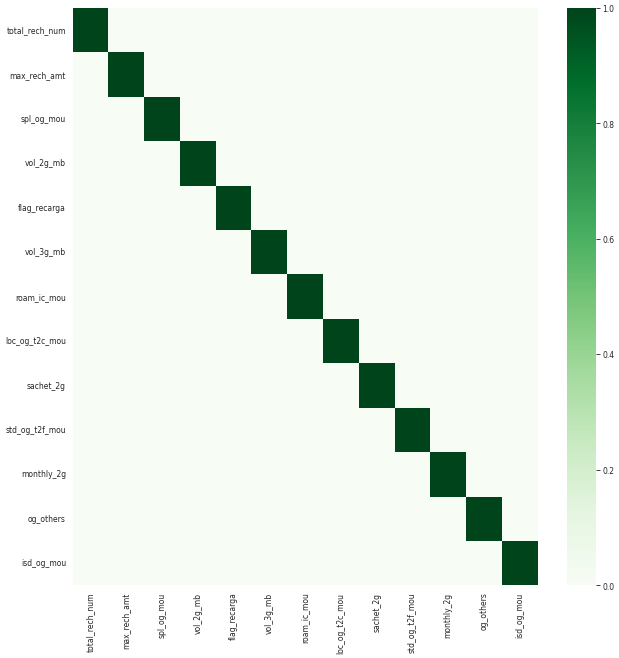

In [109]:
corr_fin = df_filtrado.corr()

plt.figure(figsize=(15, 15), dpi=50)
sns.heatmap((corr_fin>0.6), annot=False, cmap = 'Greens')
plt.show()

In [110]:
import matplotlib.pyplot as plt
import pandas as pd

def graficar_sentido_economico(df, variables, target='churn', bins=10):
    n = len(variables)
    ncols = 3
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows))
    axes = axes.flatten()

    for idx, var in enumerate(variables):
        ax = axes[idx]
        df_temp = df[[var, target]].copy()

        if pd.api.types.is_numeric_dtype(df_temp[var]):
            df_temp['grupo'] = pd.qcut(df_temp[var], q=bins, duplicates='drop')
        else:
            df_temp['grupo'] = df_temp[var]

        promedio_default = df_temp.groupby('grupo')[target].mean()
        labels = promedio_default.index.astype(str)

        ax.plot(labels, promedio_default.values, marker='o', linestyle='-')
        ax.set_title(f'{var} vs Promedio {target}')
        ax.set_xlabel('Grupo / Categoría')
        ax.set_ylabel(f'Promedio {target}')
        ax.tick_params(axis='x', rotation=45)

    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


/tmp/ipython-input-500701931.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  promedio_default = df_temp.groupby('grupo')[target].mean()
/tmp/ipython-input-500701931.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  promedio_default = df_temp.groupby('grupo')[target].mean()
/tmp/ipython-input-500701931.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  promedio_default = df_temp.groupby('grupo')[target].mean()
/

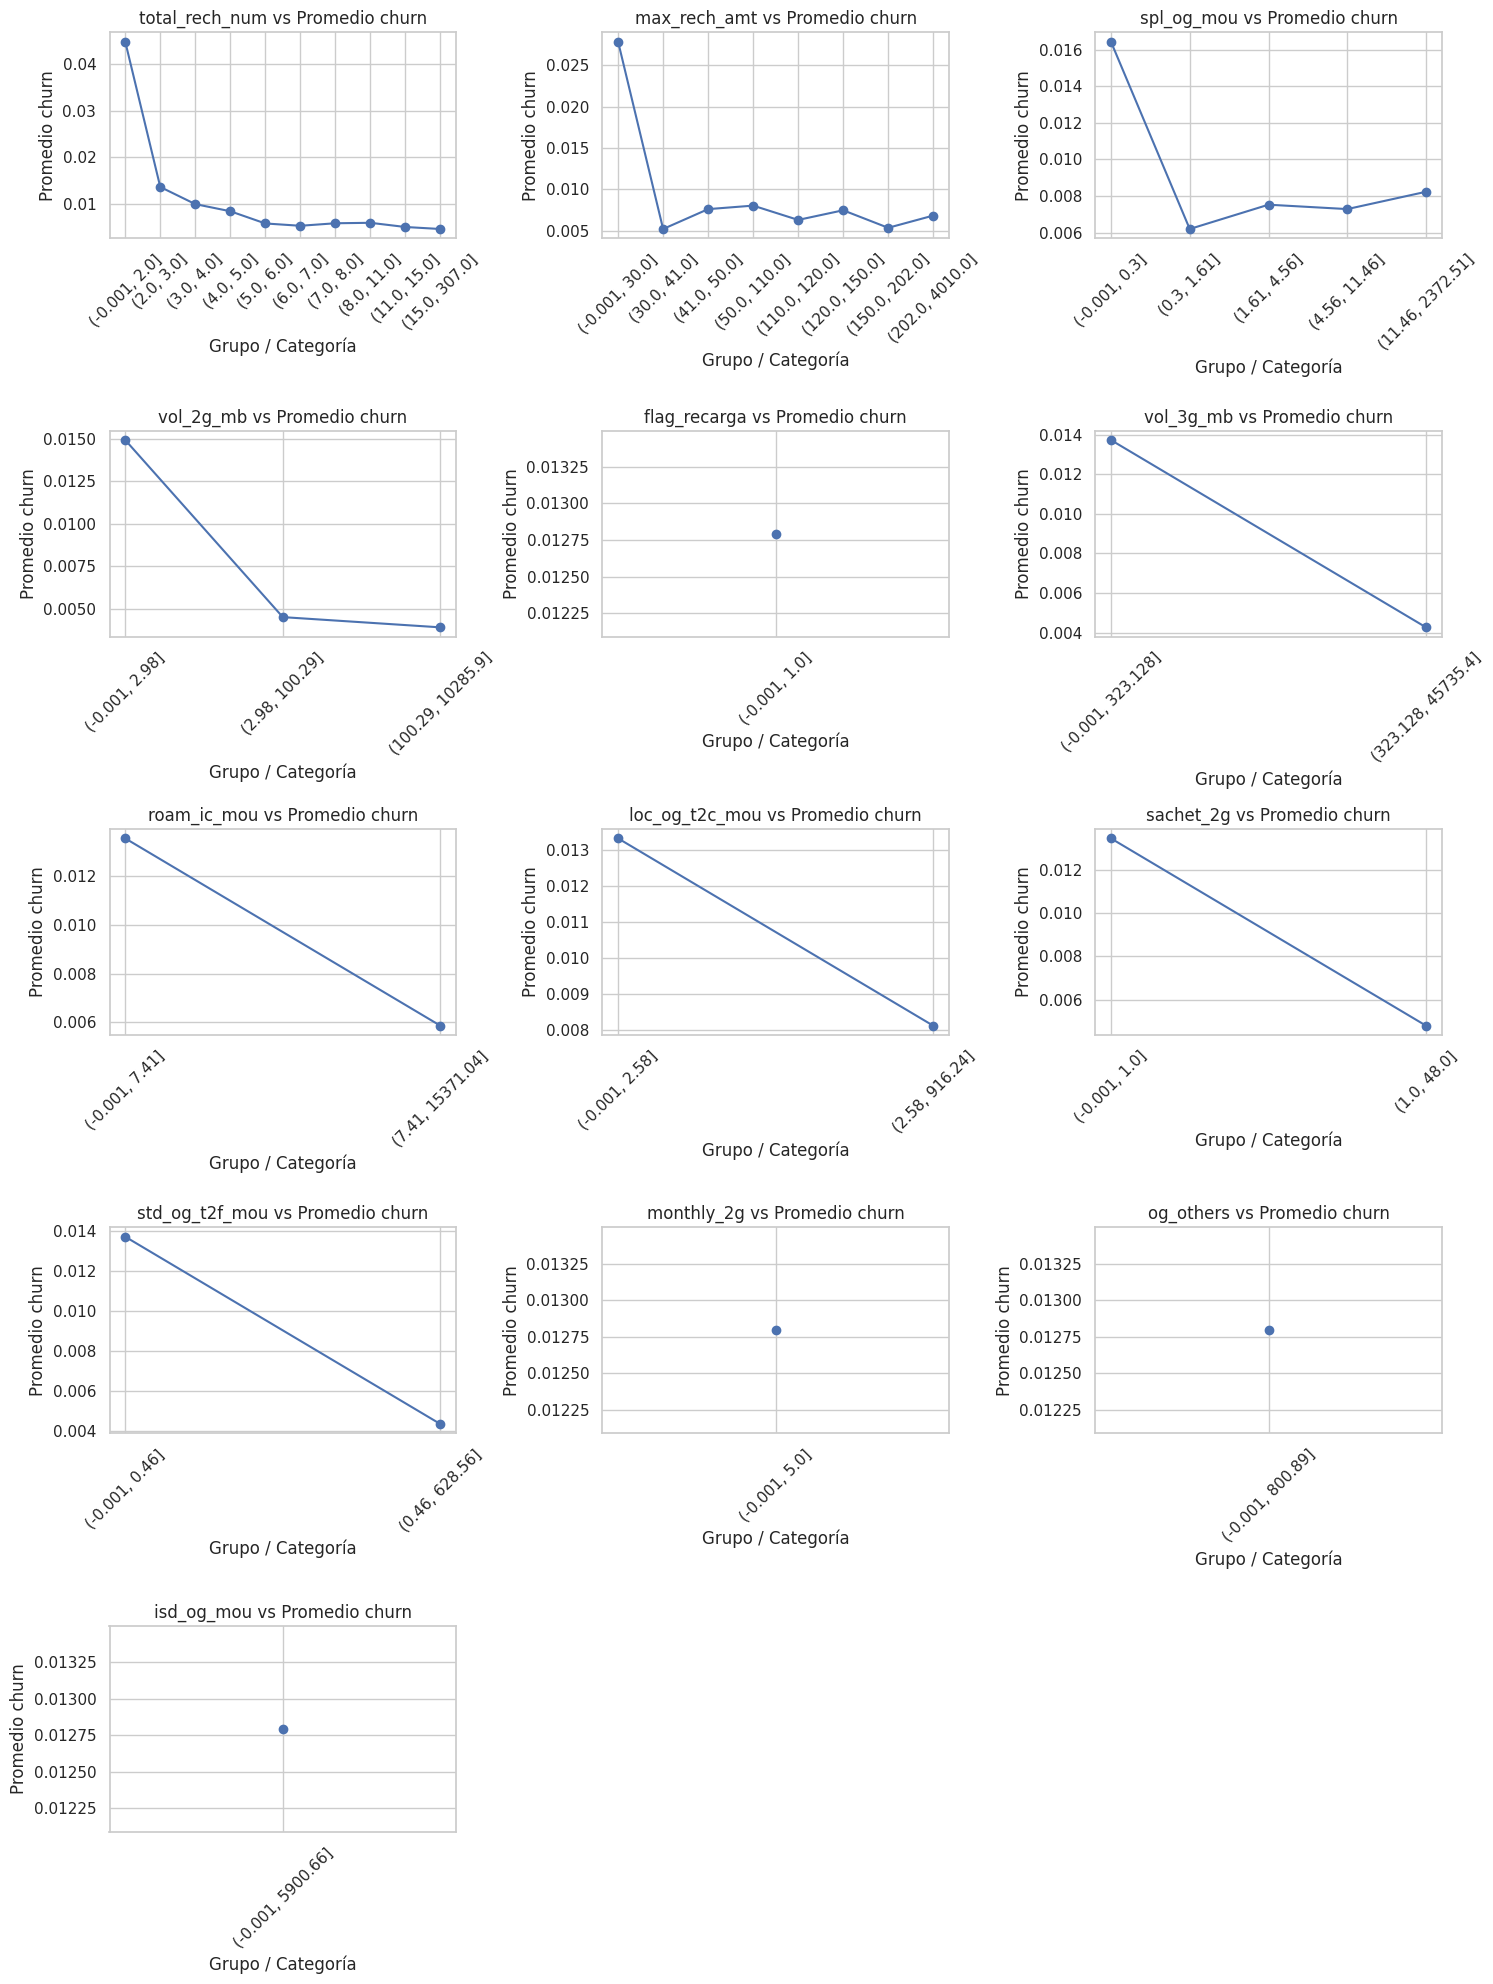

In [59]:
graficar_sentido_economico(df_train, variables_finales_filtradas, target='churn')


In [117]:
import statsmodels.api as sm
import numpy as np
import pandas as pd


variables_modelo = variables_finales_filtradas.copy()
X_train = df_train[variables_modelo].copy()
y_train = df_train['churn']
X_test  = df_test[variables_modelo].copy()
y_test  = df_test['churn']


clase_counts = y_train.value_counts()
peso_0 = 1.0
peso_1 = clase_counts[0] / clase_counts[1]
pesos_train = y_train.apply(lambda x: peso_0 if x == 0 else peso_1)


def logistic_backward_selection(X, y, weights, threshold=0.05):
    variables = list(X.columns)
    while True:
        X_const = sm.add_constant(X[variables])
        modelo = sm.Logit(y, X_const).fit(disp=0, weights=weights)
        pvalues = modelo.pvalues.drop('const')

        # Encontrar variable con p-valor máximo
        max_p = pvalues.max()
        if max_p > threshold:
            var_drop = pvalues.idxmax()
            print(f"⚠️ Eliminando variable '{var_drop}' con p-valor {max_p:.4f}")
            variables.remove(var_drop)
        else:
            print("\n✅ Modelo final con todas las variables significativas (p < 0.05).")
            break

    return modelo, variables


modelo_final, variables_significativas = logistic_backward_selection(
    X_train, y_train, pesos_train, threshold=0.05
)

# ============================
# Resultados
# ============================
print("\n📋 Resumen del modelo final:")
print(modelo_final.summary())

print("\n🎯 Variables finales significativas:")
print(variables_significativas)


/usr/local/lib/python3.12/dist-packages/statsmodels/base/optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


⚠️ Eliminando variable 'loc_og_t2c_mou' con p-valor 0.9548


/usr/local/lib/python3.12/dist-packages/statsmodels/base/optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


⚠️ Eliminando variable 'spl_og_mou' con p-valor 0.6980


/usr/local/lib/python3.12/dist-packages/statsmodels/base/optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


⚠️ Eliminando variable 'og_others' con p-valor 0.5769


/usr/local/lib/python3.12/dist-packages/statsmodels/base/optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


⚠️ Eliminando variable 'vol_3g_mb' con p-valor 0.1418


/usr/local/lib/python3.12/dist-packages/statsmodels/base/optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(


⚠️ Eliminando variable 'sachet_2g' con p-valor 0.0760


/usr/local/lib/python3.12/dist-packages/statsmodels/base/optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method newton is: tol, ridge_factor. The list of unsupported keyword arguments passed include: weights. After release 0.14, this will raise.
  warnings.warn(



✅ Modelo final con todas las variables significativas (p < 0.05).

📋 Resumen del modelo final:
                           Logit Regression Results                           
Dep. Variable:                  churn   No. Observations:               199397
Model:                          Logit   Df Residuals:                   199388
Method:                           MLE   Df Model:                            8
Date:                Sun, 21 Sep 2025   Pseudo R-squ.:                 0.08037
Time:                        08:48:23   Log-Likelihood:                -12557.
converged:                       True   LL-Null:                       -13654.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.9558      0.058    -33.443      0.000      -2.070      -1.841
total_rech_num    -0.12

In [118]:
# Paso 10: Predecir probabilidades en train y test usando variables significativas
X_train_pred = sm.add_constant(df_train[variables_significativas], has_constant='add')
X_test_pred  = sm.add_constant(df_test[variables_significativas], has_constant='add')

# Asegurar que las columnas estén alineadas con el modelo
X_train_pred = X_train_pred.reindex(columns=modelo_final.model.exog_names, fill_value=0)
X_test_pred  = X_test_pred.reindex(columns=modelo_final.model.exog_names, fill_value=0)

# Calcular probabilidades
df_train['prob_modelo_final'] = modelo_final.predict(X_train_pred)
df_test['prob_modelo_final']  = modelo_final.predict(X_test_pred)

In [119]:
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve

def fn_Indicators_Disc(truth, preds):
    # Calcular AUC
    model_auc = roc_auc_score(truth, preds)

    # Calcular el coeficiente de Gini
    model_gini = 2 * model_auc - 1

    # Calcular la estadística KS
    fpr, tpr, _ = roc_curve(truth, preds)
    model_ks = max(tpr - fpr)

    # Crear el DataFrame de salida
    out = pd.DataFrame({'Gini': [model_gini], 'KS': [model_ks]})

    return out


# Calcular los indicadores
indicadores_train = fn_Indicators_Disc(df_train['churn'], df_train['prob_modelo_final'])
print(indicadores_train)
indicadores_test = fn_Indicators_Disc(df_test['churn'], df_test['prob_modelo_final'])
print(indicadores_test)

       Gini        KS
0  0.509071  0.431127
       Gini        KS
0  0.670393  0.570991


In [121]:
def calcular_pesos_porcentuales(modelo):
    # Extraer coeficientes sin la constante
    coeficientes = modelo.params.drop('const')

    # Calcular pesos porcentuales
    suma_abs = np.sum(np.abs(coeficientes))
    pesos = (np.abs(coeficientes) / suma_abs) * 100

    return pesos.round(2)
pesos_modelo = calcular_pesos_porcentuales(modelo_final)


print("\n📊 Pesos porcentuales del mejor_modelo:")
print(pesos_modelo)


📊 Pesos porcentuales del mejor_modelo:
total_rech_num     5.61
max_rech_amt       0.18
vol_2g_mb          0.04
flag_recarga      57.61
roam_ic_mou        0.33
std_og_t2f_mou     3.06
monthly_2g        33.09
isd_og_mou         0.08
dtype: float64


In [132]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)

def evaluar_modelo_completo(modelo, variables, df, nombre, y_prob):
    """
    Evalúa un modelo logístico con métricas y curva ROC.
    Devuelve un diccionario con todas las métricas.
    """
    X = sm.add_constant(df[variables], has_constant='add')
    y_true = df['churn']
    y_pred = (y_prob >= np.mean(y_prob)).astype(int)

    # ============================
    # Métricas
    # ============================
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    matriz = confusion_matrix(y_true, y_pred)

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    # Distribución de probabilidades
    media_prob = np.mean(y_prob)
    std_prob = np.std(y_prob)

    # ============================
    # Mostrar resultados
    # ============================
    print(f"\n📊 Evaluación sobre {nombre}:")
    print("Matriz de Confusión:\n", matriz)
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC (ROC): {roc_auc:.4f}")
    print(f"Media de probabilidades: {media_prob:.4f}")
    print(f"Desviación estándar: {std_prob:.4f}")

    # Diagnóstico de rendimiento
    if f1 > 0.85:
        print("✅ Rendimiento excelente.")
    elif f1 > 0.75:
        print("✅ Rendimiento sólido.")
    elif f1 > 0.6:
        print("⚠️ Rendimiento aceptable.")
    else:
        print("❌ Rendimiento débil. Requiere ajuste.")

    # ============================
    # Graficar curva ROC
    # ============================
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC {nombre} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
    plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
    plt.title(f'Curva ROC - {nombre}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # ============================
    # Devolver resultados
    # ============================
    return {
        "dataset": nombre,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc_auc,
        "media_prob": media_prob,
        "std_prob": std_prob,
        "confusion_matrix": matriz.tolist()
    }



📊 Evaluación sobre Train:
Matriz de Confusión:
 [[121310  75536]
 [   666   1885]]
Accuracy: 0.6178
Precision: 0.0243
Recall: 0.7389
F1 Score: 0.0471
AUC (ROC): 0.7545
Media de probabilidades: 0.0128
Desviación estándar: 0.0152
❌ Rendimiento débil. Requiere ajuste.


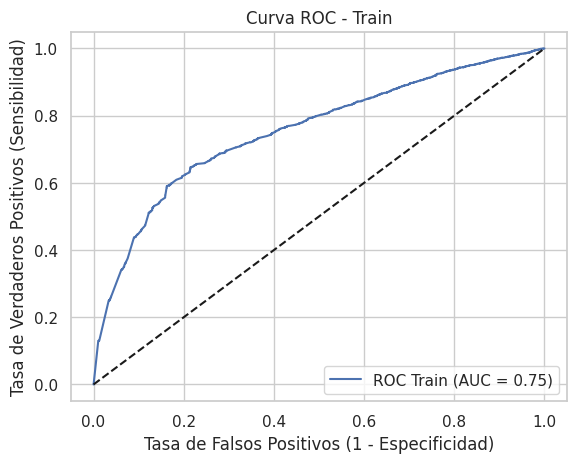


📊 Evaluación sobre Test:
Matriz de Confusión:
 [[64287 32730]
 [  311  1571]]
Accuracy: 0.6659
Precision: 0.0458
Recall: 0.8348
F1 Score: 0.0868
AUC (ROC): 0.8352
Media de probabilidades: 0.0143
Desviación estándar: 0.0191
❌ Rendimiento débil. Requiere ajuste.


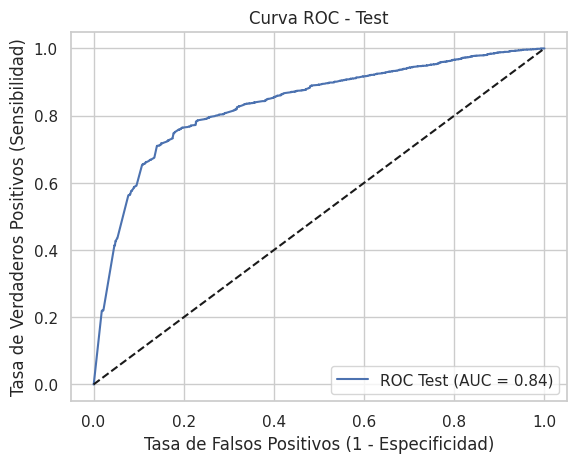


📊 Resumen comparativo Train vs Test:
  dataset  accuracy  precision    recall        f1   roc_auc  media_prob  \
0   Train  0.617838   0.024347  0.738926  0.047141  0.754536    0.012794   
1    Test  0.665912   0.045800  0.834750  0.086836  0.835197    0.014334   

   std_prob  
0  0.015226  
1  0.019146  


In [133]:
# Evaluar sobre train y test
result_train = evaluar_modelo_completo(modelo_final, variables_significativas, df_train, 'Train', df_train['prob_modelo_final'])
result_test  = evaluar_modelo_completo(modelo_final, variables_significativas, df_test,  'Test',  df_test['prob_modelo_final'])

# Convertir resultados a DataFrame comparativo
df_resultados = pd.DataFrame([result_train, result_test])
print("\n📊 Resumen comparativo Train vs Test:")
print(df_resultados.drop(columns=["confusion_matrix"]))


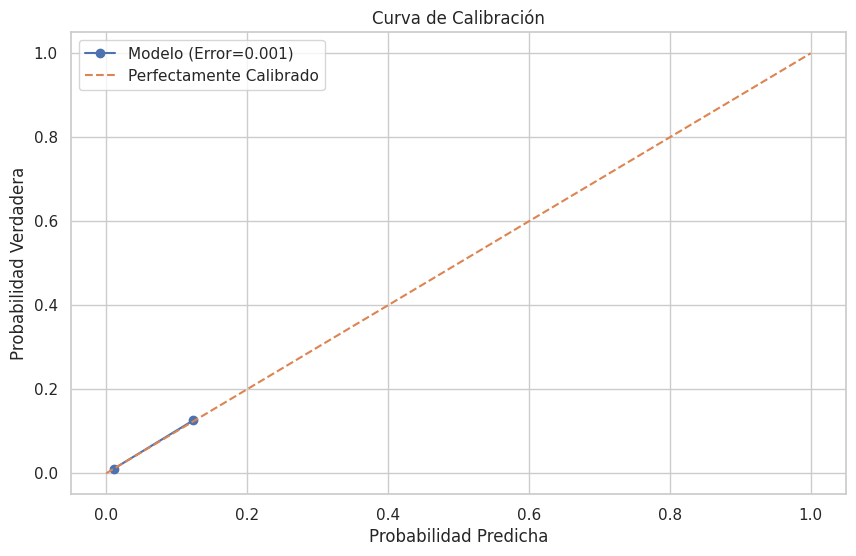

📊 Error medio de calibración: 0.0013
🎯 Calibración: 97.46%
✅ El modelo está bien calibrado.


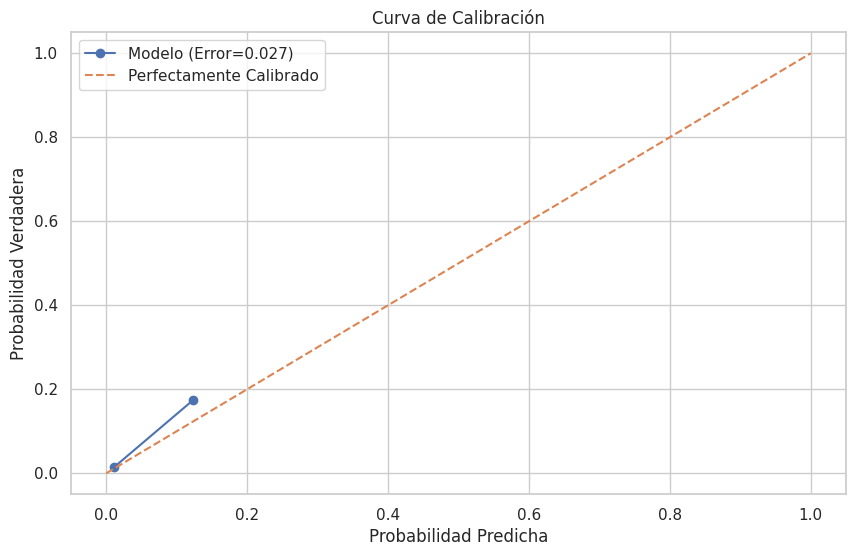

📊 Error medio de calibración: 0.0272
🎯 Calibración: 45.66%
✅ El modelo está bien calibrado.


In [135]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

def check_model_calibration(y_true, y_prob, n_bins=10, tol=0.05):
    """
    Verifica si un modelo está calibrado o descalibrado y calcula un % de calibración.

    Parámetros:
    y_true: array-like
        Etiquetas verdaderas
    y_prob: array-like
        Probabilidades predichas
    n_bins: int
        Número de bins para la curva de calibración
    tol: float
        Umbral de tolerancia (default=0.05)

    Retorna:
    dict con métricas de calibración
    """
    # Calcular la curva de calibración
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)

    # Error medio de calibración
    calibration_error = np.mean(np.abs(prob_true - prob_pred))
    calibration_score = max(0, 100 * (1 - calibration_error / tol))

    # Graficar la curva de calibración
    plt.figure(figsize=(10, 6))
    plt.plot(prob_pred, prob_true, marker='o', label=f'Modelo (Error={calibration_error:.3f})')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectamente Calibrado')
    plt.xlabel('Probabilidad Predicha')
    plt.ylabel('Probabilidad Verdadera')
    plt.title('Curva de Calibración')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Mostrar resultados
    print(f"📊 Error medio de calibración: {calibration_error:.4f}")
    print(f"🎯 Calibración: {calibration_score:.2f}%")

    if calibration_error < tol:
        print("✅ El modelo está bien calibrado.")
    else:
        print("⚠️ El modelo está descalibrado.")

    return {
        "calibration_error": calibration_error,
        "calibration_score": calibration_score
    }

# ============================
# Ejemplo de uso
# ============================
Calibrado_train_m1 = check_model_calibration(df_train['churn'], df_train['prob_modelo_final'])
Calibrado_test_m1  = check_model_calibration(df_test['churn'],  df_test['prob_modelo_final'])



🔍 Ejecutando GridSearch...
Fitting 3 folds for each of 128 candidates, totalling 384 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:03:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ Mejores hiperparámetros encontrados:
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'subsample': 0.7}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:03:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:03:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:03:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Evaluation (Train (XGB Calibrated)) ---
Umbral usado: 0.0130
Confusion matrix:
 [[179251  17595]
 [   846   1705]]
Accuracy: 0.9075  Precision: 0.0883  Recall: 0.6684  F1: 0.1561
AUC: 0.8717  GINI: 0.7433  KS: 0.5851


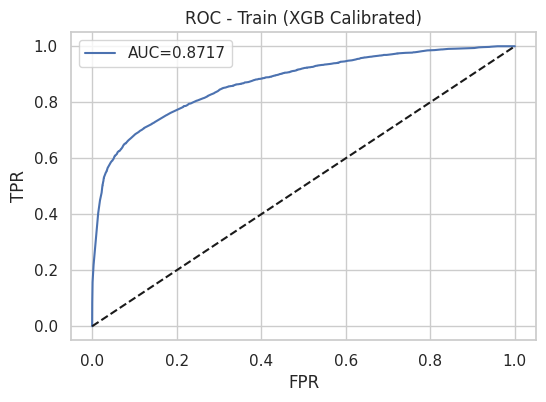

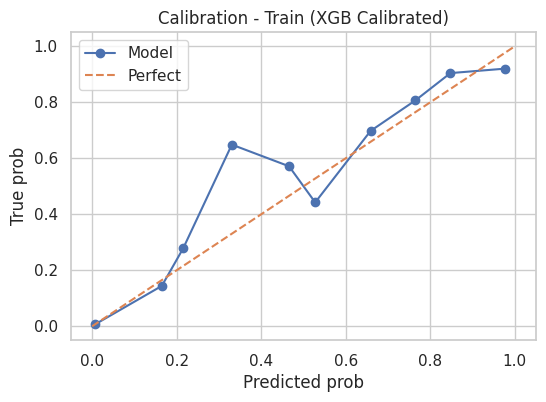


--- Evaluation (Test (XGB Calibrated)) ---
Umbral usado: 0.0126
Confusion matrix:
 [[87104  9913]
 [  451  1431]]
Accuracy: 0.8952  Precision: 0.1261  Recall: 0.7604  F1: 0.2164
AUC: 0.8805  GINI: 0.7611  KS: 0.6583


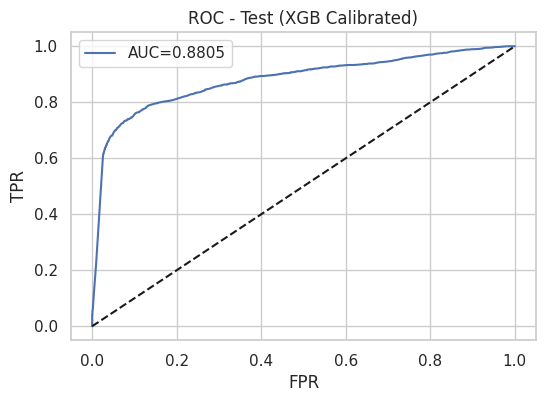

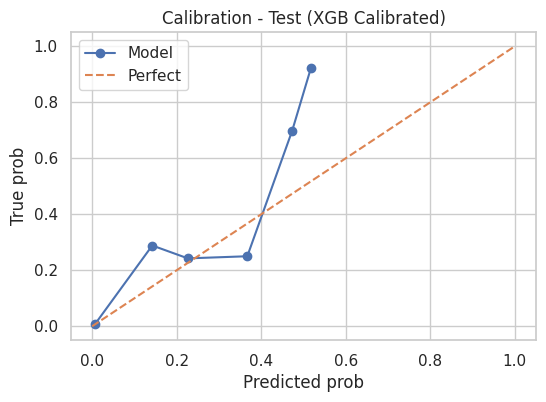


PSI Train vs Test: 0.0036

📊 Importancia de variables:
             feature         gain   gain_pct
6     loc_og_t2m_mou  1042.003174  27.581579
17      total_og_mou   575.608032  15.236210
25        std_ic_mou   538.019531  14.241251
26      total_ic_mou   305.473236   8.085805
2         offnet_mou   197.329895   5.223276
31    total_rech_amt   116.951660   3.095683
9         loc_og_mou   100.579391   2.662313
35         vol_3g_mb    87.995766   2.329227
13        std_og_mou    82.801331   2.191732
30    total_rech_num    76.138939   2.015380
18    loc_ic_t2t_mou    66.103798   1.749752
5     loc_og_t2t_mou    55.689213   1.474080
21        loc_ic_mou    48.564163   1.285482
0               arpu    47.885155   1.267509
40      flag_recarga    45.365536   1.200815
3        roam_ic_mou    30.888716   0.817617
34         vol_2g_mb    30.774092   0.814583
20    loc_ic_t2f_mou    30.510595   0.807608
33  last_day_rch_amt    29.000992   0.767649
1          onnet_mou    26.858170   0.710929

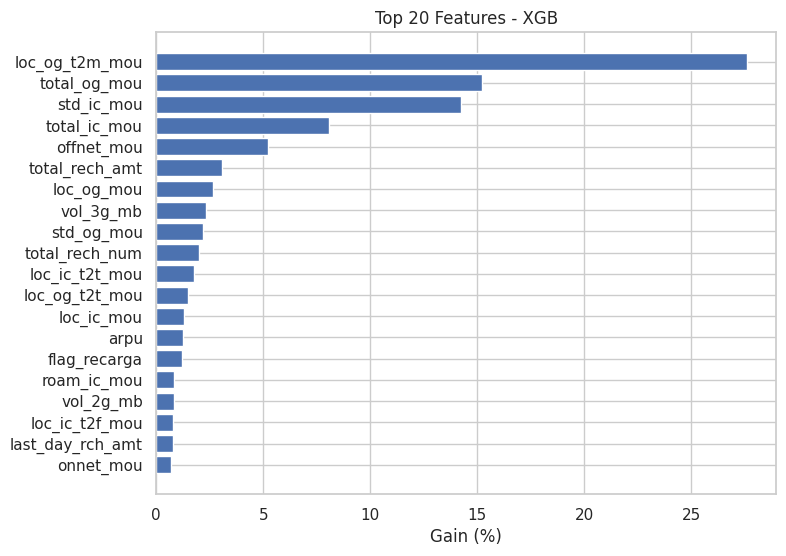


✅ Modelo XGBoost calibrado con grid search y métricas terminado.


In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, accuracy_score
)
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from scipy.stats import ks_2samp
import xgboost as xgb

# ----------------------------
# UTIL: Gini y KS
# ----------------------------
def gini_ks(y_true, y_score):
    mask = (~pd.isnull(y_true)) & (~pd.isnull(y_score))
    y_true = np.array(y_true)[mask]
    y_score = np.array(y_score)[mask]
    if len(np.unique(y_score)) <= 1 or len(np.unique(y_true)) <= 1:
        return {'Gini': np.nan, 'KS': np.nan}
    auc_val = roc_auc_score(y_true, y_score)
    gini = abs(2 * auc_val - 1)
    ks = ks_2samp(y_score[y_true == 1], y_score[y_true == 0]).statistic
    return {'Gini': gini, 'KS': ks}

# ----------------------------
# UTIL: PSI
# ----------------------------
def psi(expected, actual, buckets=10):
    expected = np.array(expected)
    actual = np.array(actual)
    breakpoints = np.percentile(expected, np.linspace(0, 100, buckets+1))
    breakpoints[0], breakpoints[-1] = -np.inf, np.inf
    psi_val = 0
    eps = 1e-8
    for i in range(len(breakpoints)-1):
        lo, hi = breakpoints[i], breakpoints[i+1]
        exp_pct = ((expected > lo) & (expected <= hi)).sum() / max(1, len(expected))
        act_pct = ((actual > lo) & (actual <= hi)).sum() / max(1, len(actual))
        exp_pct, act_pct = max(exp_pct, eps), max(act_pct, eps)
        psi_val += (exp_pct - act_pct) * np.log(exp_pct / act_pct)
    return psi_val

# ----------------------------
# UTIL: Evaluación
# ----------------------------
def evaluate_predictions(y_true, y_prob, prefix="set", plot_roc=True, plot_calibration=True):
    threshold = np.mean(y_prob)  # umbral dinámico
    y_pred = (y_prob >= threshold).astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    gk = gini_ks(y_true, y_prob)

    print(f"\n--- Evaluation ({prefix}) ---")
    print(f"Umbral usado: {threshold:.4f}")
    print("Confusion matrix:\n", cm)
    print(f"Accuracy: {acc:.4f}  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}")
    print(f"AUC: {roc_auc:.4f}  GINI: {gk['Gini']:.4f}  KS: {gk['KS']:.4f}")

    if plot_roc:
        plt.figure(figsize=(6,4))
        plt.plot(fpr, tpr, label=f'AUC={roc_auc:.4f}')
        plt.plot([0,1],[0,1],'--', color='k')
        plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title(f'ROC - {prefix}')
        plt.legend(); plt.grid(True); plt.show()

    if plot_calibration:
        prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
        plt.figure(figsize=(6,4))
        plt.plot(prob_pred, prob_true, marker='o', label='Model')
        plt.plot([0,1],[0,1],'--', label='Perfect')
        plt.xlabel('Predicted prob'); plt.ylabel('True prob'); plt.title(f'Calibration - {prefix}')
        plt.legend(); plt.grid(True); plt.show()

    return {
        'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1,
        'auc': roc_auc, 'gini': gk['Gini'], 'ks': gk['KS'], 'confusion_matrix': cm
    }

# ----------------------------
# RUN: XGBoost con grid search + calibración
# ----------------------------
excluir = ['mobile_number','date_of_last_rech','churn','last_date_of_month','prob_modelo_final','prob_xgb']
features = [f for f in df_train.columns if f not in excluir]

# Variable categórica
df_train['clasificacion_clientes_revenue'] = df_train['clasificacion_clientes_revenue'].astype('category')
df_test['clasificacion_clientes_revenue']  = df_test['clasificacion_clientes_revenue'].astype('category')

X, y = df_train[features], df_train['churn'].astype(int)
X_test, y_test = df_test[features], df_test['churn'].astype(int)

# Modelo base
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    enable_categorical=True,
    tree_method='hist'
)

# Grid de hiperparámetros
param_grid = {
    'max_depth': [2, 3],
    'learning_rate': [0.01, 0.05],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9],
    'min_child_weight': [5, 10],
    'reg_lambda': [5, 15],
    'reg_alpha': [0, 5]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    verbose=2,
    n_jobs=-1
)

print("\n🔍 Ejecutando GridSearch...")
grid.fit(X, y)

print("\n✅ Mejores hiperparámetros encontrados:")
print(grid.best_params_)

# Modelo final calibrado
best_model = grid.best_estimator_
calibrated_model = CalibratedClassifierCV(estimator=best_model, method='isotonic', cv=3)
calibrated_model.fit(X, y)

# Predicciones
y_prob_train = calibrated_model.predict_proba(X)[:,1]
y_prob_test  = calibrated_model.predict_proba(X_test)[:,1]

# Guardar predicciones en los datasets
df_train = df_train.copy()
df_test  = df_test.copy()
df_train['prob_xgb'] = y_prob_train
df_test['prob_xgb']  = y_prob_test

# Evaluación
res_train = evaluate_predictions(y, y_prob_train, prefix="Train (XGB Calibrated)")
res_test  = evaluate_predictions(y_test, y_prob_test, prefix="Test (XGB Calibrated)")

# PSI
print(f"\nPSI Train vs Test: {psi(y_prob_train, y_prob_test):.4f}")

# Importancia de variables
importance = best_model.get_booster().get_score(importance_type='gain')
imp_df = pd.DataFrame([{'feature':k,'gain':v} for k,v in importance.items()])
imp_df['gain_pct'] = 100 * imp_df['gain'] / imp_df['gain'].sum()
imp_df = imp_df.sort_values(by='gain_pct',ascending=False)

print("\n📊 Importancia de variables:")
print(imp_df.head(20))

plt.figure(figsize=(8,6))
plt.barh(imp_df['feature'].head(20), imp_df['gain_pct'].head(20))
plt.xlabel("Gain (%)"); plt.title("Top 20 Features - XGB")
plt.gca().invert_yaxis()
plt.show()

print("\n✅ Modelo XGBoost calibrado con grid search y métricas terminado.")
